In [1]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np
from scipy.stats import halfnorm

# beyasian modeling
import bambi as bmb

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

In [5]:
# Set the figure theme
sns.set_theme(style="whitegrid")
# Set the random seed
np.random.seed(123)

# generate data

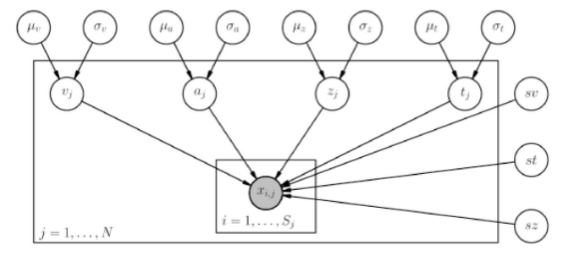

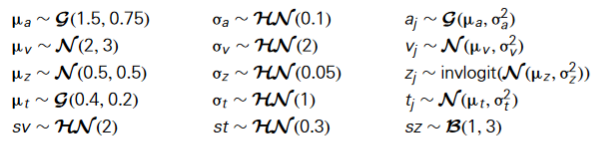

we select the range from the Wiecki et al.(2013).

to choose the most approximate parameter value as far as possible, we sample 10000 times from the distribution, and get the average. the 

In [8]:
nsize=10000
# Set the a of population level
mu_a = np.random.gamma(1.5,
                       np.sqrt(0.75),
                       size=nsize).mean()
sig_a = np.abs(np.random.normal(0,
                                np.sqrt(0.1),
                                size=nsize)).mean()
# Set the v of population level
mu_v = np.random.normal(2,
                        np.sqrt(3),
                        size=nsize).mean()
sig_v = np.abs(np.random.normal(0,
                                np.sqrt(2),
                                size=nsize)).mean()
# Set the z of population level
mu_z = np.random.gamma(0.5,
                        np.sqrt(0.5),
                        size=nsize).mean()
sig_z = np.abs(np.random.normal(0,
                                np.sqrt(0.05),
                                size=nsize)).mean()
# Set the t of population level
mu_t = np.random.gamma(0.4,
                       np.sqrt(0.2),
                       size=nsize).mean()
sig_t = np.abs(np.random.normal(0,
                                np.sqrt(1),
                                size=nsize)).mean()

In [9]:
# Set number of subjects and trials 
n_subjects = 20
trials_per_level = 50

In [10]:
# Set the subject parameter
# v
v_subj = np.random.normal(mu_v,sig_v,n_subjects)
# z
z_subj = 1/(1+np.exp(-np.random.normal(mu_z,sig_z,n_subjects)))
# a
a_subj = np.random.normal(mu_a,sig_a,n_subjects)
# t
t_subj = np.random.normal(mu_t,sig_t,n_subjects)

# dataframe
df = pd.DataFrame()
param = pd.DataFrame()
for i in range(n_subjects):
    
    # v per subject 
    v  = v_subj[i]
    # z per subject
    z  = z_subj[i]
    # a per subject
    a  = a_subj[i]
    # t per subject
    t  = t_subj[i]
    
    # set up parameters of DDM for four levels 
    level = {'v':v, 'a':a, 't':t, 'z':z, 'sv':0, 'sz':0, 'st':0}
    
    # generate simulated data
    np.random.seed(123)
    data, params = hddm.generate.gen_rand_data({'level':level},
                                                 size = trials_per_level)
    # data
    data['subj_idx'] = i
    df = df.append(data)
    
    # params
    # create dataframe
    params = pd.DataFrame([params])
    # add subject
    params['subj_idx'] = i
    # combine params
    param = param.append(params)
# reset the index
param = param.reset_index(drop=True)

## the ground truth 

In [11]:
# Select the specific coloumn
param = param[['v','a','t','z','subj_idx']]
# Store the wide data to linear regression
param_pm = param
# Transvert wide data to long data
param = param.melt(id_vars='subj_idx', 
                   var_name='param', 
                   value_name='value' )
param

,subj_idx,param,value
0,0,v,1.722996
1,1,v,0.199973
2,2,v,1.550737
3,3,v,1.380671
4,4,v,0.372153
...,...,...,...
75,15,z,0.620251
76,16,z,0.627838
77,17,z,0.561709
78,18,z,0.619965


Text(0.5, 0, 't')

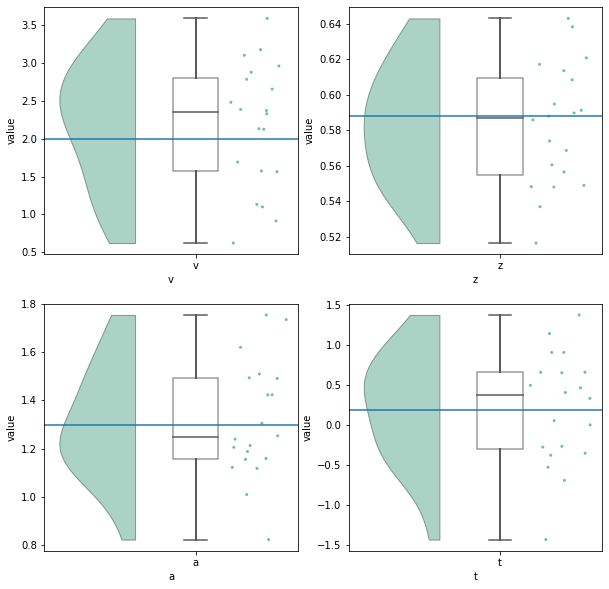

In [8]:
# Set the figure
fig, ax = plt.subplots(2,2,figsize=(10, 10))
# v
ax[0,0] = pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
ax[0,0].axhline(mu_v)
ax[0,0].set_xlabel('v')
# z
ax[0,1] = pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
ax[0,1].axhline( 1/(1+np.exp(-mu_z)))
ax[0,1].set_xlabel('z')
# a
ax[1,0] = pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
ax[1,0].axhline(mu_a)
ax[1,0].set_xlabel('a')
# t
ax[1,1] = pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1])
ax[1,1].axhline(mu_t)
ax[1,1].set_xlabel('t')

## the rt distribution

<AxesSubplot:xlabel='response', ylabel='rt'>

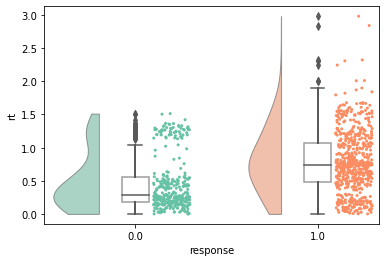

In [9]:
# the rt distribution
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2)

## hlm

In [10]:
# contrust model
m1 = bmb.Model("v ~ 1 + (1|subj_idx)", data=param_pm)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 5 seconds.
There were 714 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6090687389253235, but should be close to 0.8. Try to increase the number of tuning steps.
There were 490 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6338213154653838, but should be close to 0.8. Try to increase the number of tuning steps.
There were 788 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6088845078125622, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1412 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4804382723572901, but should be close

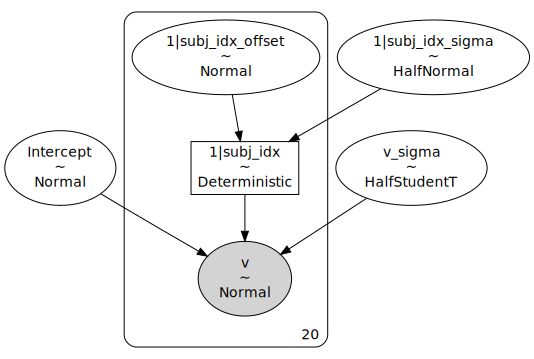

In [11]:
m1.build()
m1.graph()

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>], dtype=object)

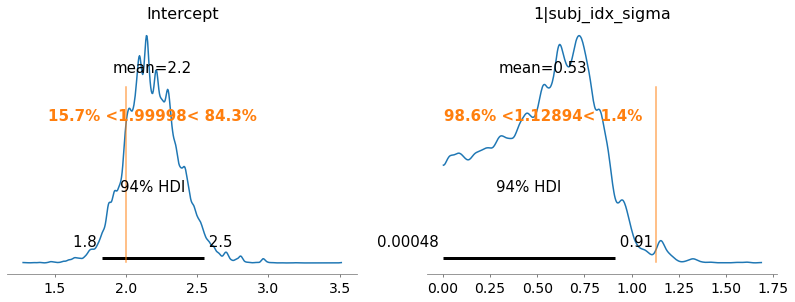

In [12]:
az.plot_posterior(res1, 
                  var_names=['Intercept','1|subj_idx_sigma'], 
                  ref_val=[mu_v,sig_v])

# fit data

In [13]:
def ms1(id, df=None, samples=None, burn=None, thin=1,save_name='ms1'):
    '''
    id: the id of cpu thread
    df: the input data
    samples: number of samples for MCMC
    burn: number of burn-in of MCMC
    thin: number of thin
    save_name: prefix of file name when saving the model object
    '''
    print('running chain {:d} for model {}'.format(id, save_name))
    # the database file
    dbname = save_name + '_chain_%i.db'%id
    # the model object store here
    mname = save_name + '_chain_%i'%id

    v_reg = {'model':'v~1','link_func':lambda x:x}
    z_reg = {'model':'z~1','link_func':lambda x:x}
    t_reg = {'model':'t~1','link_func':lambda x:x}
    a_reg = {'model':'a~1','link_func':lambda x:x}
    reg_descr = [v_reg, 
                 z_reg,
                 t_reg,
                 a_reg,]
    m = hddm.HDDMRegressor(df, 
                           reg_descr, 
                           include=['z'],
                           group_only_regressors=False,
                           keep_regressor_trace=True
                          )
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save
    m.save(mname)

    return m

In [15]:
ms1res = Parallel(n_jobs = 2)(delayed(ms1)(id = i, df = df, samples=10000,burn = 1000,thin=2, save_name = 'ms4' ) for i in range(2))

In [ ]:
ms1res = []
ms1res.append(hddm.load('ms1_chain_0'))

In [26]:
%%time
InfData_ms1 = InferenceDataFromHDDM(ms1res, nppc = 100, save_name="ms1")

start converting ms1


  0%|          | 0/2 [00:00<?, ?it/s]

started to generate posterior predicitves


NotImplementedError: Supply a grouping so that at most 1 observed node codes for each group.

started to generate posterior predicitves


In [ ]:
az.plot_trace(InfData_ms1)

## the sampling trace

Plotting v_Intercept
Plotting v_Intercept_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting t_Intercept
Plotting t_Intercept_std
Plotting a_Intercept
Plotting a_Intercept_std


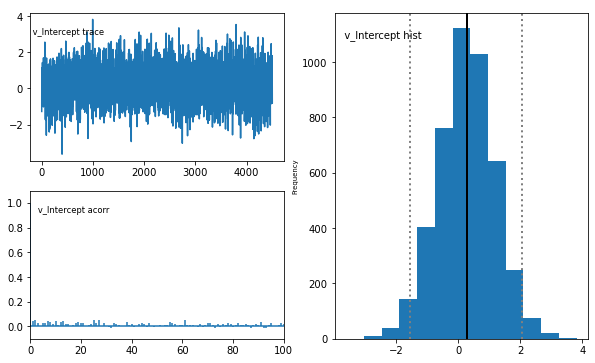

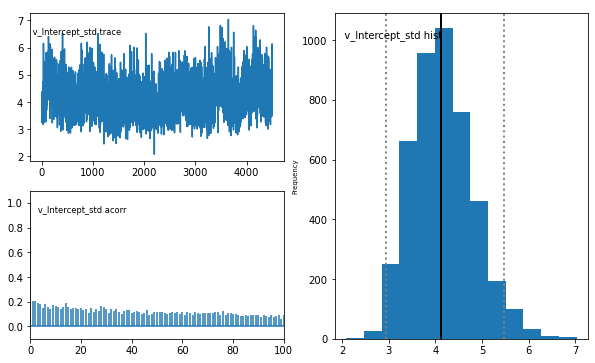

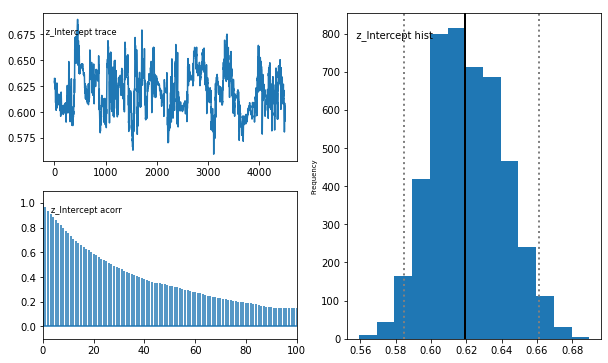

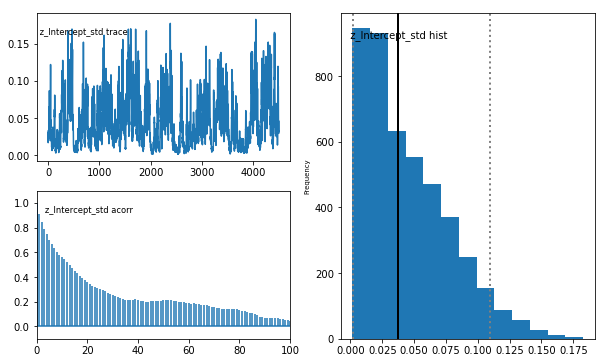

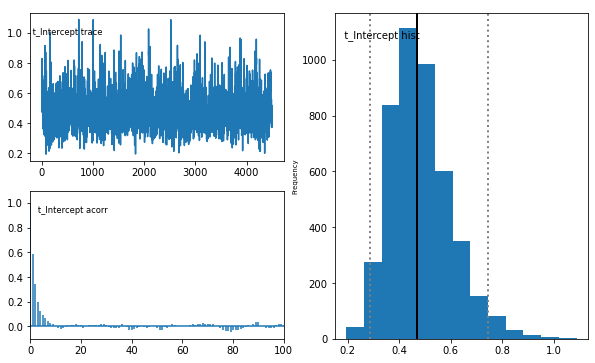

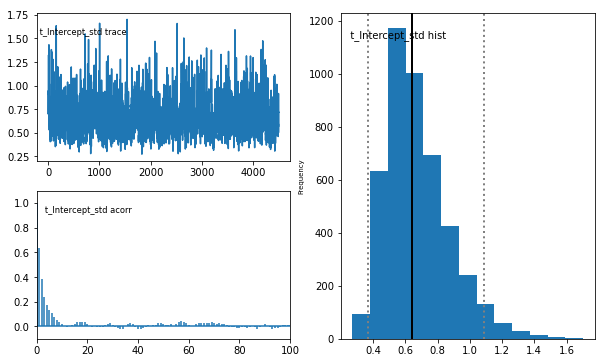

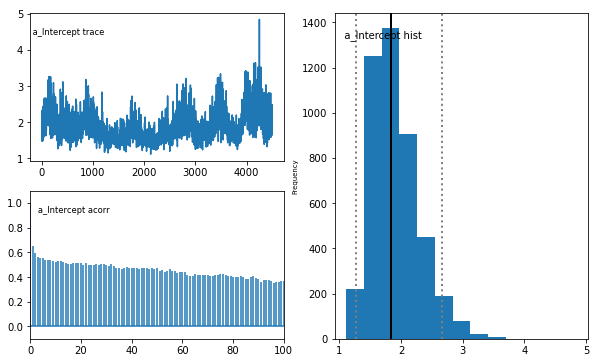

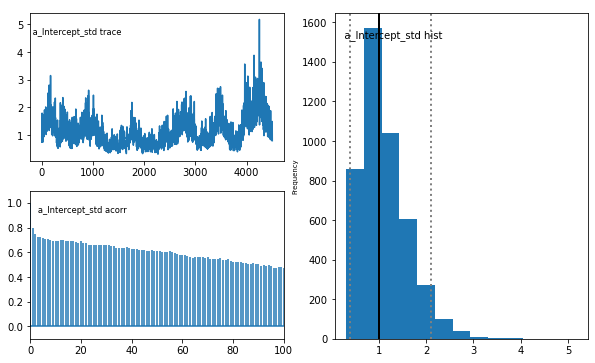

In [17]:
ms1res[0].plot_posteriors()

In [18]:
ms1res[0].get_traces().to_csv('m1res.csv')

In [6]:
m1res_trace = pd.read_csv('m1res.csv')

## the group effect

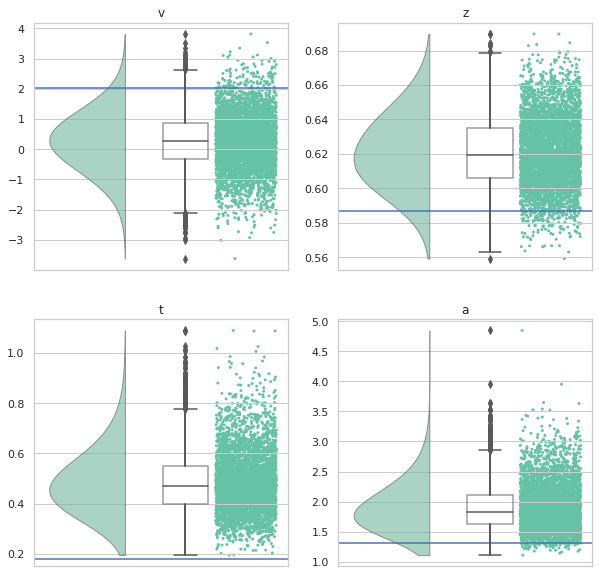

In [13]:
pms = ['v','z','t','a']
# create figure
f,ax = plt.subplots(2,2,figsize=(10,10))
for i,pm in enumerate(pms):
    if pm != 'z':
        varname = os.path.join(str(pm +'_Intercept'))
        data = m1res_trace[varname]
        # ground parameter of group effect
        gpm = eval(os.path.join('mu_'+pm))
    else:
        varname = os.path.join(str(pm +'_Intercept_trans'))
        data = 1/(1+np.exp(-m1res_trace[varname]))
        # ground parameter of group effect
        gpm =  1/(1+np.exp(-eval(os.path.join('mu_'+pm))))
    
    # raincloud
    ax_i = ax[i//2,i%2]
    ax_i = pt.RainCloud(data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(gpm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(pm)

## the subject effcet

### v

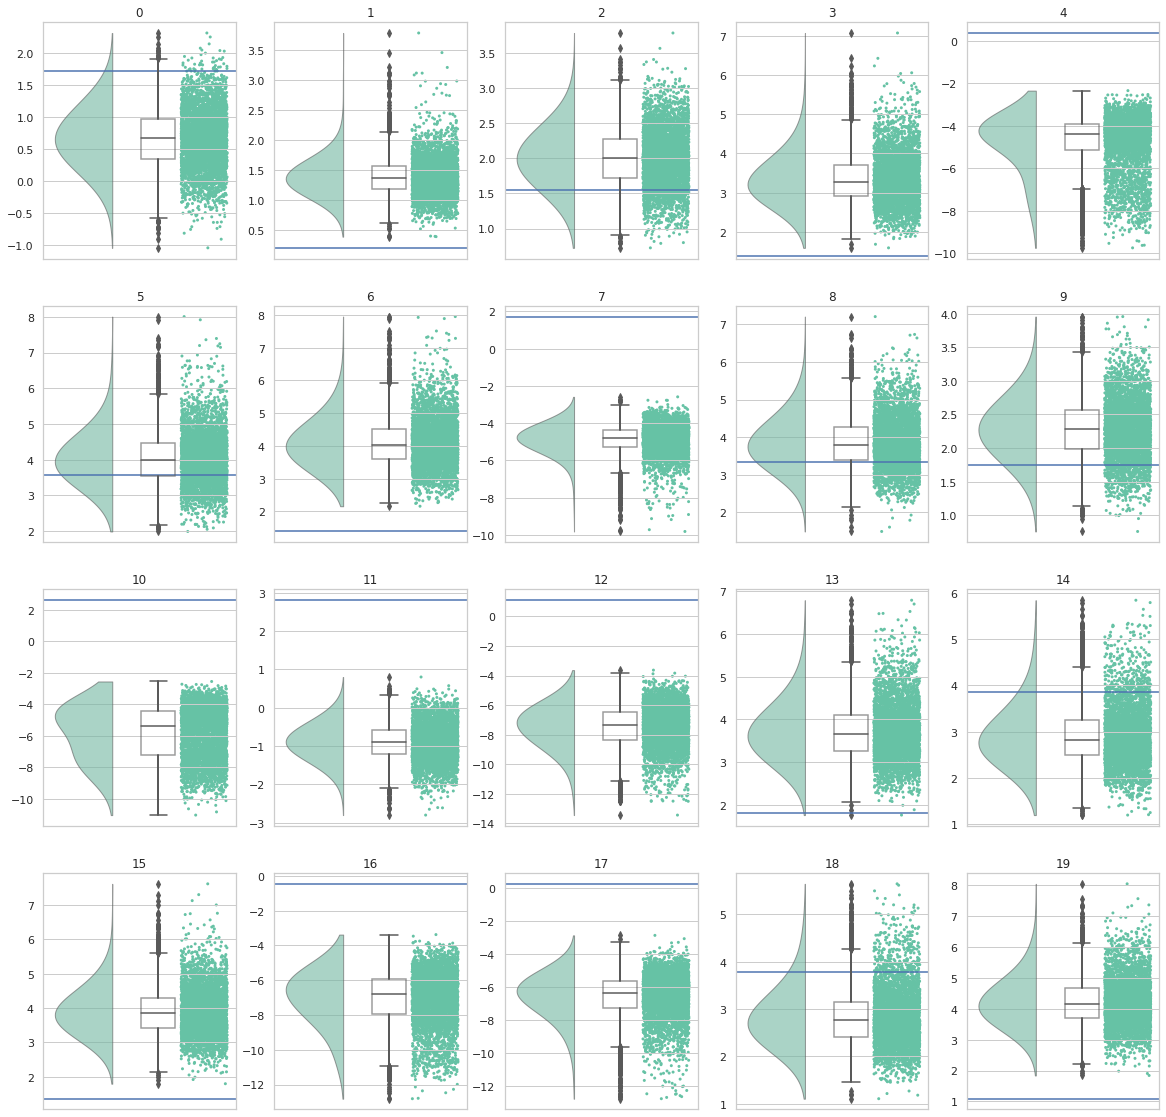

In [18]:
param = 'v'
# create figure
f,ax = plt.subplots(4,5,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'v'].values[0]
    # raincloud
    ax_i = ax[i//5,i%5]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

### z

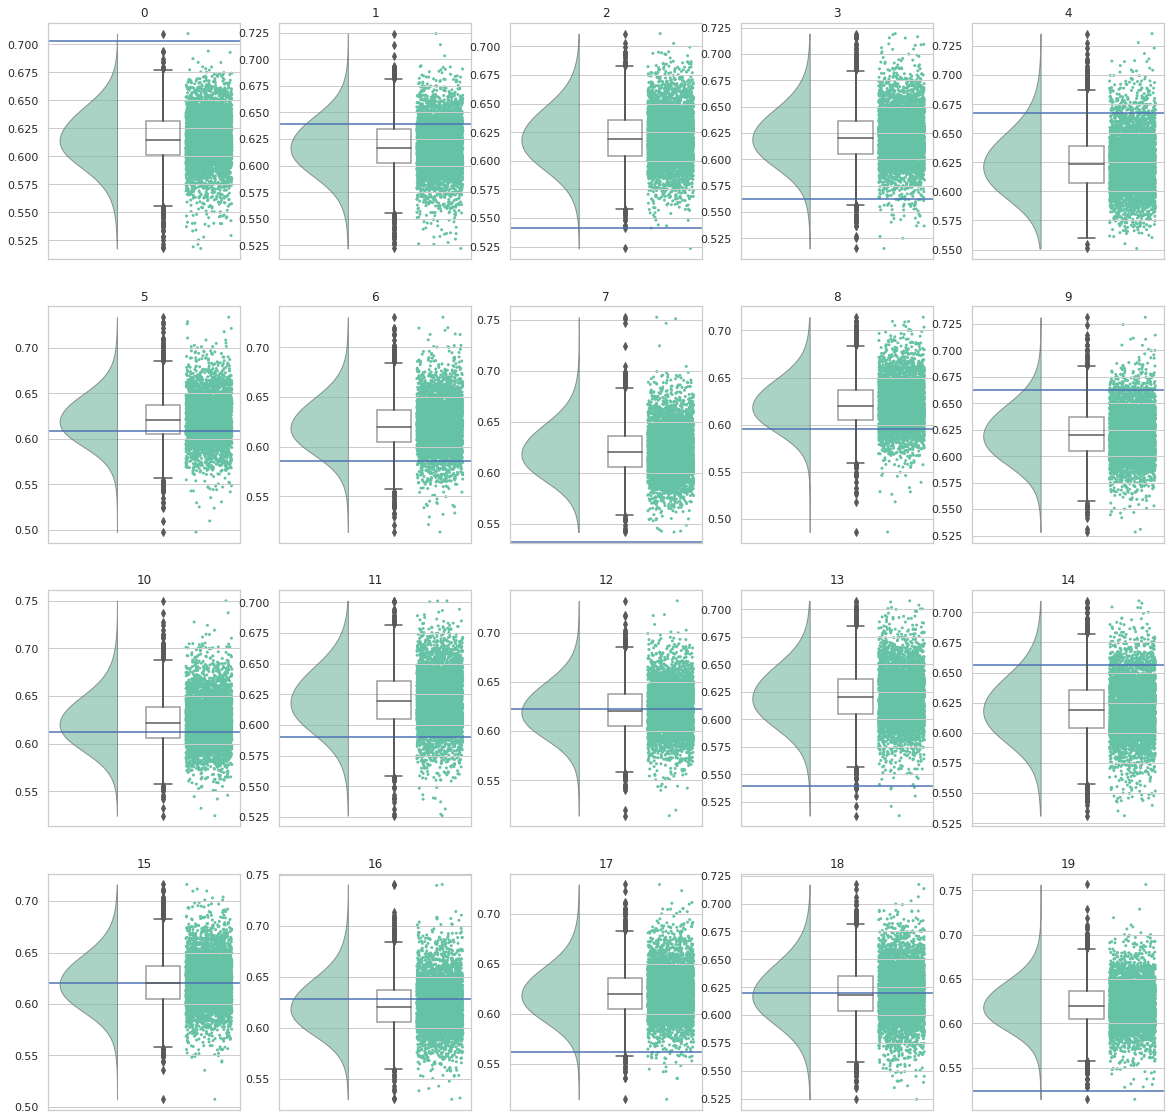

In [22]:
param = 'z'
# create figure
f,ax = plt.subplots(4,5,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj_trans.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'z'].values[0]
    # raincloud
    ax_i = ax[i//5,i%5]
    ax_i = pt.RainCloud(data = 1/(1+np.exp(-m1res_trace[varname])), 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

### t

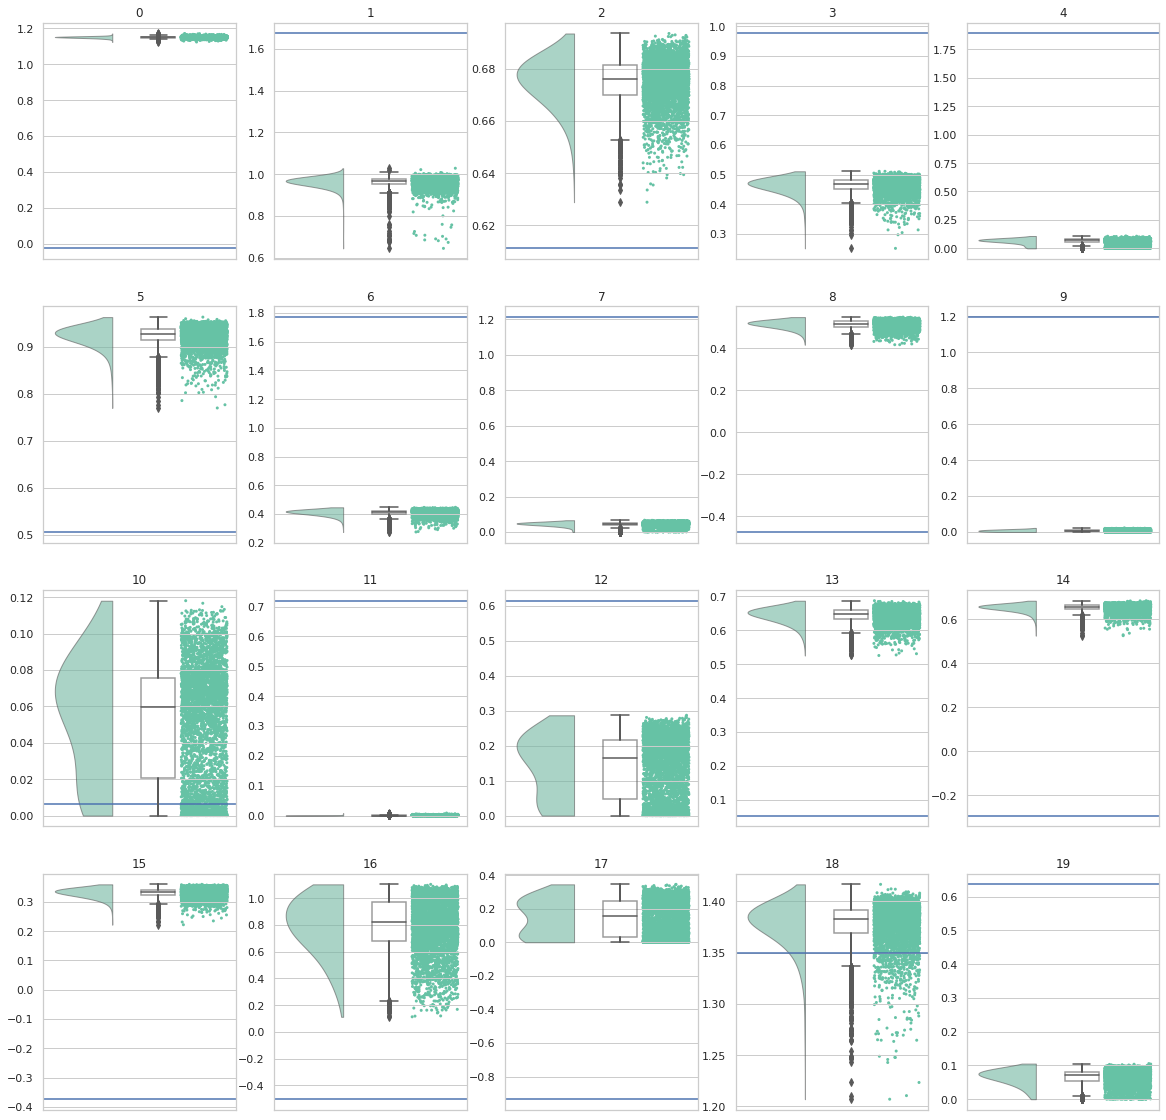

In [24]:
param = 't'
# create figure
f,ax = plt.subplots(4,5,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'t'].values[0]
    # raincloud
    ax_i = ax[i//5,i%5]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

### a

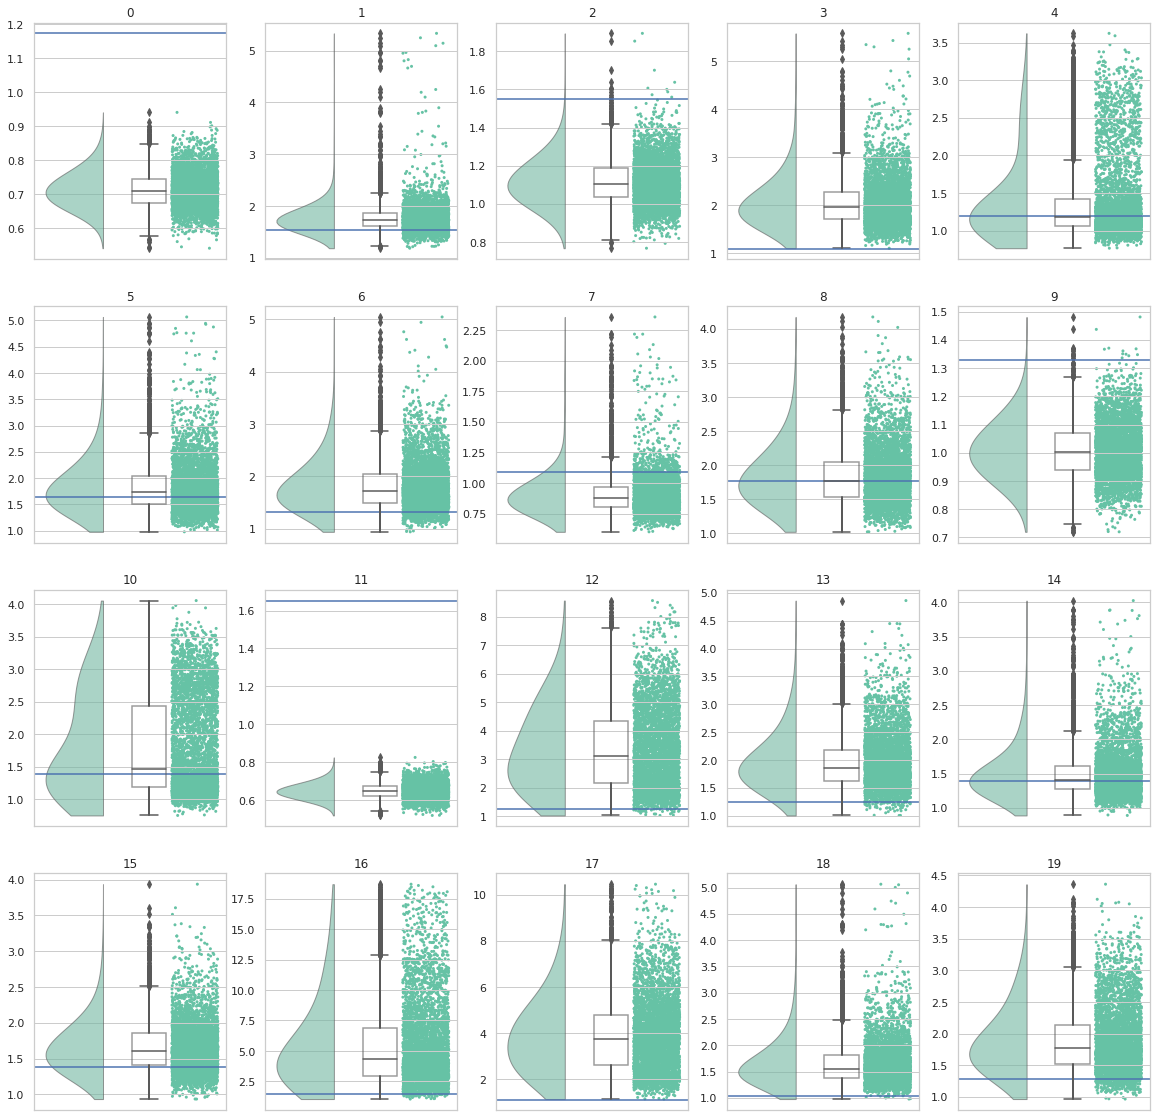

In [26]:
param = 'a'
# create figure
f,ax = plt.subplots(4,5,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'a'].values[0]
    # raincloud
    ax_i = ax[i//5,i%5]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)